# Dependency Parsing with Eisner
Par Louis GERARD & Tiago CORTINHAL

In [1]:
import sys
venv_root = '/var/lib/vz/data/g13005245/DEEP/'
sys.path.append(venv_root + 'lib/python3.5/site-packages')

import warnings
warnings.filterwarnings('ignore')

import time
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Features 1

We start building a model on these features :
- Governor POS
- Dependant POS
- Distance between these words

### Read data

We read the conllu file to get aall the info we need. In order to make this reusable, we can add any feature to the final list by adding its index to `features_enabled`. Here we have :
- the index, to identify our token
- the part of speech, which we want to pass to our model
- the governor index, to build pairs

In [111]:
def read_conllu(conllu_filename):
    sentences = []

    features = ['INDEX', 'FORM', 'LEMMA', 'POS', 'X1', 'MORPHO', 'GOV', 'LABEL', 'X2', 'X3']
    features_enabled = [0, 3, 6, 7]
    root = [0, 'ROOT', -1, 'root']

    columns = []
    for i, f in enumerate(features):
        if i in features_enabled:
            columns.append(f)

    with open(conllu_filename, 'r', encoding='utf-8') as conllu_file:
        sentence = []
        for i in range(len(features_enabled)):
            sentence.append([root[i]])
        tokens = []
        for line in conllu_file:
            if line[0] == '\n':
                if len(sentence) > 1:
                    sentences.append(sentence)
                    sentence = []
                    for i in range(len(features_enabled)):
                        sentence.append([root[i]])
            elif line[0] == '#':
                pass
            else:
                tokens = line.split('\t')
                if '-' not in tokens[0]:
                    for i, j in enumerate(features_enabled):
                        sentence[i].append(tokens[j])
    return sentences

sentences = read_conllu("UD_French-GSD/fr_gsd-ud-train.conllu")
pd.DataFrame(sentences[3]).T

,0,1,2,3
0,0,ROOT,-1,root
1,1,ADV,5,advmod
2,2,PUNCT,5,punct
3,3,DET,4,det
4,4,NOUN,5,nsubj
5,5,VERB,0,root
6,6,DET,7,det
7,7,NOUN,5,obj
8,8,PUNCT,5,punct


Now we have all the data we need, we can process it to build our dataset. 

We can't pass directly the part of speech tags to our model, so we need to encod it to an one hot vector. We can compute the distances with the indexes. 

We can still reuse this code by adapting `index_i`, `pos_i` and `governor_i` to the previous final result and process the added data in `create_example()`. 

The targets are a bit simplitic because all we need to compute it is the distance. A single neuron with linear activation function, a weight of 1 for the distance and weights of 0 for the POS can do the job. 

In [3]:
def get_sentence(sentences):
    for sentence in sentences:
        yield np.array(sentence).T
        
pos_2_1hot = {
    'ADJ': 1,
    'ADP': 2,
    'ADV': 3,
    'AUX': 4,
    'CCONJ': 5,
    'DET': 6,
    'INTJ': 7,
    'NOUN': 8,
    'NUM': 9,
    'PART': 10,
    'PRON': 11,
    'PROPN': 12,
    'PUNCT': 13,
    'SCONJ': 14,
    'SYM': 15,
    'VERB': 16,
    'X': 17,
    'ROOT': 0
}

labels_2_1hot = {
    'acl': 0,
    'advcl': 1,
    'advmod': 2,
    'amod': 3,
    'appos': 4,
    'aux': 5,
    'case': 6,
    'cc': 7,
    'ccomp': 8,
    'clf': 9,
    'compound': 10,
    'conj': 11,
    'cop': 12,
    'csubj': 13,
    'dep': 14,
    'det': 15,
    'discourse': 16,
    'dislocated': 17,
    'expl': 18,
    'fixed': 19,
    'flat': 20,
    'goeswith': 21,
    'iobj': 22,
    'list': 23,
    'mark': 24,
    'nmod': 25,
    'nsubj': 26,
    'nummod': 27,
    'obj': 28,
    'obl': 29,
    'orphan': 30,
    'parataxis': 31,
    'punct': 32,
    'reparandum': 33,
    'root': 34,
    'vocative': 35,
    'xcomp': 36
}
onehot_2_label = {v: k for k, v in labels_2_1hot.items()}

index_i = 0
pos_i = 1
governor_i = 2
label_i = 3

def create_example(w1, w2, positive=True):
    dist = int(w2[index_i]) - int(w1[index_i])

    pos1 = np.zeros(len(pos_2_1hot))
    pos1[pos_2_1hot[w1[pos_i]]] = 1

    pos2 = np.zeros(len(pos_2_1hot))
    pos2[pos_2_1hot[w2[pos_i]]] = 1
    
    x = np.concatenate(([dist], pos1, pos2))
    label = np.zeros(37)
    
    y = [0, 0]
    if positive:
        if w1[governor_i] == w2[index_i]:
            g, d = w2, w1
            y[0] = 1
        else:
            d, g = w2, w1
            y[1] = 1
        l = d[label_i].split(':', 1)[0]
        label[labels_2_1hot[l]] = 1
    return x, np.concatenate((y, label))

def create_dataset(sentences, with_negatives=False):
    x = []
    y = []
    for s in get_sentence(sentences):
        for w1 in s:
            if w1[index_i] == '0':
                continue
            w2 = s[int(w1[governor_i])]
            
            if w1[index_i] > w2[index_i]:
                w2, w1 = w1, w2

            x_token, y_token = create_example(w1, w2)

            x.append(x_token)
            y.append(y_token)
            
            if with_negatives:
                i = np.random.randint(len(s) - 2)
                if i >= int(w1[index_i]):
                    i += 1
                if i >= int(w2[index_i]):
                    i += 1
                w2_negative = s[i]
                x_token, y_token = create_example(w1, w2, False)
                x.append(x_token)
                y.append(y_token)

    return np.array(x), np.array(y)

In [22]:
x, y = create_dataset(sentences, True)
x.shape, y.shape

((713276, 37), (713276, 39))

### A first model

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

model = keras.models.Sequential()
model.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))

model.compile('sgd', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


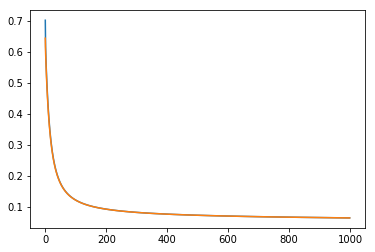

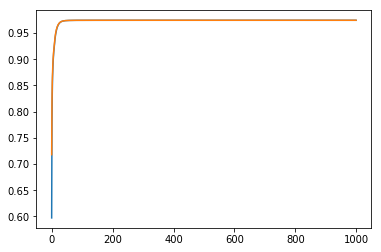

In [24]:
h = model.fit(x_train, y_train, epochs=1000, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

## Some tests

In [148]:
dist = 1
pos1 = np.zeros(18)
pos1[pos_2_1hot['DET']] = 1
pos2 = np.zeros(18)
pos2[pos_2_1hot['VERB']] = 1
prediction = model.predict(np.concatenate(([dist], pos1, pos2)).reshape(1, -1))[0]
i = np.argmax(prediction[2:])
label = onehot_2_label[i]
label, prediction[i+2], prediction[:2]

('det', 0.49814516, array([0.9813493 , 0.01780364], dtype=float32))

In [149]:
dist = -1
pos1 = np.zeros(18)
pos1[pos_2_1hot['DET']] = 1
pos2 = np.zeros(18)
pos2[pos_2_1hot['VERB']] = 1
prediction = model.predict(np.concatenate(([dist], pos1, pos2)).reshape(1, -1))[0]
i = np.argmax(prediction[2:])
label = onehot_2_label[i]
label, prediction[i+2], prediction[:2]

('det', 0.4450788, array([0.08914704, 0.9143471 ], dtype=float32))

In [150]:
dist = 1
pos1 = np.zeros(18)
pos1[pos_2_1hot['ADJ']] = 1
pos2 = np.zeros(18)
pos2[pos_2_1hot['NOUN']] = 1
prediction = model.predict(np.concatenate(([dist], pos1, pos2)).reshape(1, -1))[0]
i = np.argmax(prediction[2:])
label = onehot_2_label[i]
label, prediction[i+2], prediction[:2]

('amod', 0.44582435, array([0.96826035, 0.02192572], dtype=float32))

In [151]:
dist = -1
pos1 = np.zeros(18)
pos1[pos_2_1hot['ADJ']] = 1
pos2 = np.zeros(18)
pos2[pos_2_1hot['NOUN']] = 1
prediction = model.predict(np.concatenate(([dist], pos1, pos2)).reshape(1, -1))[0]
i = np.argmax(prediction[2:])
label = onehot_2_label[i]
label, prediction[i+2], prediction[:2]

('amod', 0.42850152, array([0.05369734, 0.92958754], dtype=float32))

In [41]:
sentence = np.array(sentences[3]).T
for s in sentence:
    print(s)
    x, _ = create_example(s, sentence[int(s[governor_i])])
    prediction = model.predict(x.reshape(1, -1))[0]

    i = np.argmax(prediction[2:])
    label = onehot_2_label[i]
    print(label, prediction[i+2], prediction[:2], '\n')

['0' 'ROOT' '0' 'root']
root 0.2754599 [0.35425016 0.71756625] 

['1' 'ADV' '5' 'advmod']
nsubj 0.11829152 [0.7782369  0.23771323] 

['2' 'PUNCT' '5' 'punct']
punct 0.5850483 [0.87273633 0.15875621] 

['3' 'DET' '4' 'det']
det 0.8240393 [0.9298349  0.07244185] 

['4' 'NOUN' '5' 'nsubj']
nsubj 0.14788458 [0.4372541 0.569142 ] 

['5' 'VERB' '0' 'root']
obl 0.30802694 [0.2807896 0.7867949] 

['6' 'DET' '7' 'det']
det 0.8240393 [0.9298349  0.07244185] 

['7' 'NOUN' '5' 'obj']
nsubj 0.14730823 [0.54832536 0.45747492] 

['8' 'PUNCT' '5' 'punct']
punct 0.60429376 [0.94363093 0.0714094 ] 



# Eisner's algorithm

Now we have our model, we can use it to create the dependency parsing itself with Eisner's algorithm. 

[Explanatory video](https://youtu.be/du9VQaFEyeA)

In [112]:
sentence = np.array(sentences[3]).T
pd.DataFrame(sentence)

,0,1,2,3
0,0,ROOT,-1,root
1,1,ADV,5,advmod
2,2,PUNCT,5,punct
3,3,DET,4,det
4,4,NOUN,5,nsubj
5,5,VERB,0,root
6,6,DET,7,det
7,7,NOUN,5,obj
8,8,PUNCT,5,punct


In [138]:
def eisner(sentence, model=None, perfect=False):
    n = sentence.shape[0]

    full_left = []
    full_right = []
    part_left = []
    part_right = []
    
    part_max = []
    full_left_max = []
    full_right_max = []
    
    labels = []
    
    for i in range(n):
        full_left.append([0])
        full_right.append([0])
        part_left.append([0])
        part_right.append([0])
        
        part_max.append([0])
        full_left_max.append([0])
        full_right_max.append([0])
        
        labels.append([])

    for m in range(1, n):
        for i1 in range(n - m):
            i2 = i1 + m
            
            if perfect:
                prediction = np.zeros(39)
                prediction[0] = 0
                prediction[1] = 0
                label = None
                if sentence[i1][governor_i] == sentence[i2][index_i]:
                    prediction[0] = 1
                    label = sentence[i1][label_i]
                elif sentence[i2][governor_i] == sentence[i1][index_i]:
                    prediction[1] = 1
                    label = sentence[i2][label_i]
            else:
                x, _ = create_example(sentence[i1], sentence[i2])
                prediction = model.predict(x.reshape(1, -1))[0]

                i = np.argmax(prediction[2:])
                label = onehot_2_label[i]
                
            labels[i1].append(label)

            max_full = -1
            max_q = -1
            for q in range(i2 - i1):
                q_line = q + i1
                current = full_left[i1][q] + full_right[q_line + 1][i2 - q_line - 1]
                
                if i1 == 3 and i2 == 5:
                    print('part', q, current)
                
                if current > max_full:
                    max_full = current
                    max_q = q_line
            
            if i1 == 3 and i2 == 5:
                print(prediction)
            part_left[i1].append(max_full + prediction[1])
            part_right[i1].append(max_full + prediction[0])
            part_max[i1].append(max_q)
            
            max_full_l = -1
            max_full_r = -1
            max_q_l = -1
            max_q_r = -1
            for q in range(i2 - i1):
                q_line = q + i1
                current_r = full_right[i1][q] + part_right[q_line][i2 - q_line]
                current_l = part_left[i1][q + 1] + full_left[q_line + 1][i2 - q_line - 1]
                
                if i1 == 3 and i2 == 5:
                    print('full r', q, current_r)
                    print('full l', q + 1, current_l)

                if current_l > max_full_l:
                    max_full_l = current_l
                    max_q_l = q_line + 1
                if current_r > max_full_r:
                    max_full_r = current_r
                    max_q_r = q_line

            full_left[i1].append(max_full_l)
            full_right[i1].append(max_full_r)
            full_left_max[i1].append(max_q_l)
            full_right_max[i1].append(max_q_r)
            
#     print(pd.DataFrame(full_right))
#     print(pd.DataFrame(part_left))
            
    return full_left_max, full_right_max, part_max, labels

# full_left, full_right, part, labels = eisner(sentence, model)
true_full_left, true_full_right, true_part, true_labels = eisner(sentence, perfect=True)

part 0 1.0
part 1 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
full r 0 1.0
full l 1 0.0
full r 1 2.0
full l 2 1.0


## Results

In [27]:
def color(val):
    if val:
        color = 'green'
    else:
        color = 'red'
    return 'background-color: %s' % color

In [51]:
full_left = pd.DataFrame(full_left)
full_left

,0,1,2,3,4,5,6,7,8
0,0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0
1,0,1.0,1.0,1.0,1.0,5.0,5.0,5.0,NaN
2,0,2.0,2.0,4.0,5.0,5.0,5.0,NaN,NaN
3,0,3.0,4.0,5.0,5.0,5.0,NaN,NaN,NaN
4,0,4.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN
5,0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN
6,0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
7,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
true_full_left = pd.DataFrame(true_full_left)
true_full_left

,0,1,2,3,4,5,6,7,8
0,0,1.0,1.0,1.0,1.0,5.0,5.0,5.0,5.0
1,0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN
2,0,3.0,3.0,4.0,6.0,6.0,3.0,NaN,NaN
3,0,4.0,4.0,5.0,5.0,5.0,NaN,NaN,NaN
4,0,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN
5,0,6.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN
6,0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
7,0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df = full_left == true_full_left
df.style.applymap(color)

,0,1,2,3,4,5,6,7,8
0,True,True,True,True,True,True,False,True,True
1,True,True,True,True,True,False,True,True,False
2,True,True,True,False,False,True,True,False,False
3,True,True,False,False,True,True,False,False,False
4,True,True,False,True,True,False,False,False,False
5,True,True,True,True,False,False,False,False,False
6,True,True,False,False,False,False,False,False,False
7,True,True,False,False,False,False,False,False,False
8,True,False,False,False,False,False,False,False,False


In [122]:
full_right = pd.DataFrame(full_right)
full_right

,0,1,2,3,4,5,6,7,8
0,0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
1,0,2.0,3.0,4.0,5.0,5.0,5.0,5.0,NaN
2,0,3.0,4.0,5.0,5.0,5.0,5.0,NaN,NaN
3,0,4.0,5.0,4.0,4.0,4.0,NaN,NaN,NaN
4,0,5.0,6.0,7.0,8.0,NaN,NaN,NaN,NaN
5,0,6.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN
6,0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
7,0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
true_full_right = pd.DataFrame(true_full_right)
true_full_right

,0,1,2,3,4,5,6,7,8
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2,0,2.0,2.0,2.0,2.0,2.0,5.0,NaN,NaN
3,0,3.0,3.0,3.0,3.0,5.0,NaN,NaN,NaN
4,0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN
5,0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN
6,0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
7,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df = full_right == true_full_right
df.style.applymap(color)

,0,1,2,3,4,5,6,7,8
0,True,True,False,False,False,False,True,False,True
1,True,True,False,False,True,True,True,True,False
2,True,True,False,True,True,True,True,False,False
3,True,True,False,True,True,True,False,False,False
4,True,True,False,False,False,False,False,False,False
5,True,True,False,True,False,False,False,False,False
6,True,True,True,False,False,False,False,False,False
7,True,True,False,False,False,False,False,False,False
8,True,False,False,False,False,False,False,False,False


In [34]:
part = pd.DataFrame(part)
part

,0,1,2,3,4,5,6,7,8
0,0,0.0,1.0,2.0,2.0,4.0,5.0,5.0,7.0
1,0,1.0,1.0,1.0,1.0,5.0,5.0,7.0,NaN
2,0,2.0,2.0,2.0,2.0,2.0,7.0,NaN,NaN
3,0,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN
4,0,4.0,5.0,5.0,7.0,NaN,NaN,NaN,NaN
5,0,5.0,5.0,7.0,NaN,NaN,NaN,NaN,NaN
6,0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
7,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
true_part = pd.DataFrame(true_part)
true_part

,0,1,2,3,4,5,6,7,8
0,0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,7.0
1,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2,0,2.0,2.0,2.0,5.0,5.0,2.0,NaN,NaN
3,0,3.0,3.0,5.0,5.0,3.0,NaN,NaN,NaN
4,0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN
5,0,5.0,5.0,7.0,NaN,NaN,NaN,NaN,NaN
6,0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
7,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df = part == true_part
df.style.applymap(color)

,0,1,2,3,4,5,6,7,8
0,True,True,False,False,False,False,True,True,True
1,True,True,True,True,True,False,False,False,False
2,True,True,True,True,True,True,False,False,False
3,True,True,True,True,True,True,False,False,False
4,True,True,False,False,False,False,False,False,False
5,True,True,True,True,False,False,False,False,False
6,True,True,True,False,False,False,False,False,False
7,True,True,False,False,False,False,False,False,False
8,True,False,False,False,False,False,False,False,False


In [37]:
labels = pd.DataFrame(labels)
labels

,0,1,2,3,4,5,6,7
0,root,punct,root,root,root,root,root,punct
1,punct,advmod,nmod,advmod,advmod,nmod,punct,None
2,punct,punct,punct,punct,punct,punct,None,None
3,det,det,det,det,det,None,None,None
4,nsubj,nmod,nmod,punct,None,None,None,None
5,obl,obl,punct,None,None,None,None,None
6,det,det,None,None,None,None,None,None
7,punct,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None


In [105]:
true_labels = pd.DataFrame(true_labels)
true_labels

,0,1,2,3,4,5,6,7
0,root,root,root,root,root,root,root,root
1,advmod,advmod,advmod,advmod,advmod,advmod,advmod,None
2,punct,punct,punct,punct,punct,punct,None,None
3,det,det,det,det,det,None,None,None
4,nsubj,nsubj,nsubj,nsubj,None,None,None,None
5,root,root,root,None,None,None,None,None
6,det,det,None,None,None,None,None,None
7,obj,None,None,None,None,None,None,None
8,None,None,None,None,None,None,None,None


In [39]:
df = labels == true_labels
df.style.applymap(color)

,0,1,2,3,4,5,6,7
0,True,False,True,True,True,True,True,False
1,False,True,False,True,True,False,False,False
2,True,True,True,True,True,True,False,False
3,True,True,True,True,True,False,False,False
4,True,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False
6,True,True,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False


## Decomposition

In [131]:
def decompose_full(i1, i2, full_left, full_right, part, labels, left=True):
    print('full', left, i1, i2)
    if i1 < i2:
        if left:
            q = full_left[i1][i2 - i1]
            f1 = decompose_part
            f2 = decompose_full
        else:
            q = full_right[i1][i2 - i1]
            f1 = decompose_full
            f2 = decompose_part
#             print(q)
        f1(i1, q, full_left, full_right, part, labels, left)
        f2(q, i2, full_left, full_right, part, labels, left)

def decompose_part(i1, i2, full_left, full_right, part, labels, left=True):
    print('part', left, i1, i2)
    if left:
        sentence_predicted[i2][governor_i] = i1
        sentence_predicted[i2][label_i] = labels[i1][i2 - i1 - 1]
    else:
        sentence_predicted[i1][governor_i] = i2
        sentence_predicted[i1][label_i] = labels[i1][i2 - i1 - 1]
        
    if i1 < i2:
        q = part[i1][i2 - i1]
#         print(q)
        decompose_full(i1, q, full_left, full_right, part, labels, True)
        decompose_full(q + 1, i2, full_left, full_right, part, labels, False)

In [139]:
sentence_predicted = sentence.copy()
decompose_full(0, 8, true_full_left, true_full_right, true_part, true_labels)
pd.DataFrame(sentence_predicted)

full True 0 8
part True 0 5
full True 0 0
full False 1 5
full False 1 1
part False 1 5
full True 1 1
full False 2 5
full False 2 2
part False 2 5
full True 2 2
full False 3 5
full False 3 4
full False 3 3
part False 3 4
full True 3 3
full False 4 4
part False 4 5
full True 4 4
full False 5 5
full True 5 8
part True 5 8
full True 5 7
part True 5 7
full True 5 5
full False 6 7
full False 6 6
part False 6 7
full True 6 6
full False 7 7
full True 7 7
full False 8 8
full True 8 8


,0,1,2,3
0,0,ROOT,-1,root
1,1,ADV,5,advmod
2,2,PUNCT,5,punct
3,3,DET,4,det
4,4,NOUN,5,nsubj
5,5,VERB,0,root
6,6,DET,7,det
7,7,NOUN,5,obj
8,8,PUNCT,5,punct


In [140]:
df = pd.DataFrame(sentence_predicted == sentence)[[governor_i, label_i]]
df.style.applymap(color)

,2,3
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
5,True,True
6,True,True
7,True,True
8,True,True
